# Pre

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from torch import nn, optim
from tqdm import tqdm, trange
from torch.utils.data import random_split

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import cv2
import numpy as np

# import lightning as L
# import torchmetrics
# from torchmetrics import Metric
from torch.optim import Adam
import torchmetrics
# from torchmetrics import JaccardIndex
# from lightning.pytorch.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt
import PIL
import random
from torchvision import models


In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device}")

device = torch.device(device)

Using device: cuda


In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 8
num_epochs = 20
num_workers = 1
data_dir="drive/MyDrive/VOCSegmentationBinaryMask"
min_epochs = 1
max_epochs = 3
precision = 16
IGNORE_INDEX = 255
N_CLASSES=21



In [ ]:
class CreatePointMask:
    """
    A callable class to transform a segmentation mask into a sparse point-based mask.
    For each object class present in the mask, it randomly selects 3 pixels.
    """

    def __init__(self, num_points=None, max_num=4):
        if num_points is None:
            num_points = random.randint(2, max_num)
        self.num_points = num_points

    def __call__(self, mask):
        """
        Args:
            mask (torch.Tensor): The input segmentation mask of shape [H, W].

        Returns:
            torch.Tensor: The sparse point mask of shape [H, W].
        """
        # Create an empty mask to store the points, filled with the background class (0)

        point_mask = torch.zeros_like(mask)

        # Find the unique object classes present in the mask
        unique_classes = torch.unique(mask)
        # print(unique_classes)

        for class_id in unique_classes:
            # Skip the background (0) and void/ignore (255) classes
            if class_id == 255:
                continue

            # Find the coordinates of all pixels belonging to the current class
            # torch.where returns a tuple of tensors (row_indices, col_indices)
            coords = torch.where(mask == class_id)

            # Determine how many pixels to sample
            # If the object has fewer pixels than num_points, take all of them
            num_pixels = len(coords[0])
            num_to_sample = min(self.num_points, num_pixels)
            if num_to_sample > 0:
                # Generate random indices to select from the available coordinates
                # torch.randperm is great for random, non-repeating sampling
                sample_indices = torch.randperm(num_pixels)[:num_to_sample]
                # Get the coordinates of the randomly selected pixels
                sampled_rows = coords[1][sample_indices]
                sampled_cols = coords[2][sample_indices]

                if class_id == 0:
                  point_mask[0, sampled_rows, sampled_cols] = 21
                else:
                  # Place the points with their original class ID onto the new mask
                  point_mask[0, sampled_rows, sampled_cols] = class_id

        return point_mask


In [ ]:
# 1. Define the custom dataset class
class VOCSegmentationBinaryMask(Dataset):
    """
    A custom PyTorch Dataset for VOC Segmentation that converts multi-class
    masks into binary (0 or 1) masks.
    - 0: Background
    - 1: Any object (foreground)
    """

    def __init__(
        self,
        root,
        image_set="train",
        download=True,
        transform=None,
        target_transform=None,
    ):
        """
        Args:
            root (string): Root directory of the VOC dataset.
            image_set (string, optional): Selects the dataset to load, e.g., 'train', 'val'.
            download (bool, optional): If true, downloads the dataset from the internet
                and puts it in root directory. If dataset is already downloaded, it is not
                downloaded again.
            transform (callable, optional): A function/transform that takes in a PIL image
                and returns a transformed version. E.g, `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`
            target_transform (callable, optional): A function/transform that takes in the
                target mask (PIL image) and transforms it. This is applied *before* binarization.
        """
        self.voc_dataset = datasets.VOCSegmentation(
            root=root,
            image_set=image_set,
            download=download,
            # We handle transforms ourselves in __getitem__ to ensure mask binarization
            # and allow custom transforms for image and target separately.
            transform=None,
            target_transform=None,
        )
        if transform is None:
            self.transform = v2.Compose(
                [
                    v2.Resize((256, 256)),
                    v2.ToImage(),
                    v2.ToDtype(torch.float32, scale=True),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]
            )
        else:
            self.transform = transform

        if target_transform is None:
            self.target_transform = v2.Compose(
                [
                    v2.Resize((256, 256), interpolation=v2.InterpolationMode.NEAREST),
                    v2.ToImage(),
                    v2.ToDtype(torch.long, scale=False),
                ]
            )
        else:
            self.target_transform = target_transform
        self.create_post_mask = CreatePointMask(3)

    def __len__(self):
        return len(self.voc_dataset)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding binary mask.

        The original VOC masks have different integer values for different object classes
        and 255 for "void" (ignored) regions. This method converts all object pixels
        (values 1-20) to 1 and background/void pixels (0 and 255) to 0.
        """
        img, mask = self.voc_dataset[idx]

        # Apply image transformations (e.g., resize, to_tensor, normalize)
        img = self.transform(img)

        # Apply target (mask) transformations (e.g., resize)
        mask = self.target_transform(mask)
        points = self.create_post_mask(mask)
        points = v2.ToDtype(torch.float32, scale=False)(points)
        return img, mask, points




In [ ]:
image_transforms = v2.Compose(
    [
        v2.Resize((256, 256)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

target_transforms = v2.Compose(
    [
        v2.Resize((256, 256), interpolation=v2.InterpolationMode.NEAREST),
        v2.ToImage(),
        v2.ToDtype(torch.long, scale=False),
    ]
)


In [ ]:
# Create an instance of your custom dataset
print(
    "Loading VOCSegmentation dataset (this may take a while if downloading for the first time)..."
)
try:
    train_dataset = VOCSegmentationBinaryMask(
        root=data_dir,
        image_set="train",  # You can change this to 'val' for validation set
        download=False,
        transform=image_transforms,
        target_transform=target_transforms,
    )
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print(
        "Please ensure you have internet connection for downloading or check the data_dir."
    )
    exit()  # Exit the script if dataset loading fails

# Create a DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# print(f"Dataset size: {len(train_dataset)} samples")
# print(f"Number of batches (with batch_size={batch_size}): {len(train_loader)}")


Loading VOCSegmentation dataset (this may take a while if downloading for the first time)...
Dataset loaded successfully.


In [ ]:
# Create an instance of your custom dataset
print(
    "Loading VOCSegmentation dataset (this may take a while if downloading for the first time)..."
)
try:
    val_dataset = VOCSegmentationBinaryMask(
        root=data_dir,
        image_set="val",  # You can change this to 'val' for validation set
        download=False,
        transform=image_transforms,
        target_transform=target_transforms,
    )
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print(
        "Please ensure you have internet connection for downloading or check the data_dir."
    )
    exit()  # Exit the script if dataset loading fails

# Create a DataLoader for batching and shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# print(f"Dataset size: {len(val_dataset)} samples")
# print(f"Number of batches (with batch_size={batch_size}): {len(val_loader)}")


Loading VOCSegmentation dataset (this may take a while if downloading for the first time)...
Dataset loaded successfully.


In [ ]:
# Define the standard PASCAL VOC color map
VOC_COLOR_MAP = np.array(
    [
        [0, 0, 0],  # 0=main-background
        [128, 0, 0],  # 1=aeroplane
        [0, 128, 0],  # 2=bicycle
        [128, 128, 0],  # 3=bird
        [0, 0, 128],  # 4=boat
        [128, 0, 128],  # 5=bottle
        [0, 128, 128],  # 6=bus
        [128, 128, 128],  # 7=car
        [64, 0, 0],  # 8=cat
        [192, 0, 0],  # 9=chair
        [64, 128, 0],  # 10=cow
        [192, 128, 0],  # 11=diningtable
        [64, 0, 128],  # 12=dog
        [192, 0, 128],  # 13=horse
        [64, 128, 128],  # 14=motorbike
        [192, 128, 128],  # 15=person
        [0, 64, 0],  # 16=pottedplant
        [128, 64, 0],  # 17=sheep
        [0, 192, 0],  # 18=sofa
        [128, 192, 0],  # 19=train
        [0, 64, 128],  # 20=tvmonitor
        [255, 255, 255],  # 21=point-background
    ],
    dtype=np.uint8,
)


def mask_to_rgb(mask, color_map):
    """Converts a segmentation mask to an RGB image."""
    # Convert the PyTorch tensor to a NumPy array if it isn't already
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()

    # Create an empty RGB image
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Map each class index to its corresponding color
    for class_index in np.unique(mask):
        if class_index < len(color_map):
            rgb_image[mask == class_index] = color_map[class_index]

    return rgb_image


# # Use the function on our predicted mask
# index = 10
# rgb_pred_image = mask_to_rgb(dataset[index][1][0], VOC_COLOR_MAP)

# # Display the result
# print(f"Shape of the final RGB image: {rgb_pred_image.shape}")
# plt.imshow(rgb_pred_image)
# plt.title("Visualized Model Output")
# plt.axis("off")
# plt.show()


In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class ConvBLock(nn.Module):
    """Downscaling with double conv then maxpool"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:

class DiceLoss(nn.Module):
    def __init__(self, n_classes, ignore_index=None):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=1)

        # --- Start of fix ---

        # Create a "clean" copy of the targets for one-hot encoding
        targets_for_onehot = targets.clone()

        # If an ignore_index is specified, create a mask for it
        if self.ignore_index is not None:
            ignore_mask = (targets == self.ignore_index)
            # Set ignored pixels to a valid class (e.g., 0) in the copy
            targets_for_onehot[ignore_mask] = 0

        # One-hot encode the cleaned target. This will now not error out.
        one_hot_targets = F.one_hot(targets_for_onehot, num_classes=self.n_classes).permute(0, 3, 1, 2)

        # If an ignore_index was used, ensure the one-hot vectors for those
        # original positions are all zeros, so they don't contribute to the loss.
        if self.ignore_index is not None:
            one_hot_targets = one_hot_targets * (~ignore_mask.unsqueeze(1))

        # --- End of fix ---

        # Calculate intersection and union for each class
        intersection = torch.sum(probs * one_hot_targets, dim=(2, 3))
        cardinality = torch.sum(probs + one_hot_targets, dim=(2, 3))

        # Dice score per class (add a small epsilon for numerical stability)
        dice_score = (2. * intersection + 1e-7) / (cardinality + 1e-7)

        # Return the mean of (1 - dice_score) across all classes
        return 1 - dice_score.mean()


In [ ]:

def show_predictions(image, mask, prediction, point_coords, point_colors):
    """Plots the image, masks, and points with per-class coloring."""
    # Detach tensors and move to CPU
    image_np = image.detach().cpu().permute(1, 2, 0).numpy()
    mask_np = mask.detach().cpu().numpy()
    prediction_np = prediction.detach().cpu().numpy()
    points_np = point_coords.detach().cpu().numpy()
    # point_colors is already a NumPy array, no conversion needed

    # Normalize image for display
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Input Image with Colored Points
    axes[0].imshow(image_np)
    axes[0].scatter(
        points_np[:, 0], # x coordinates
        points_np[:, 1], # y coordinates
        c=point_colors,  # Use the list of colors for each point
        marker='*',
        s=150,
        edgecolor='white', # White edge helps visibility on dark colors
        linewidth=1
    )
    axes[0].set_title("Input Image + Points")
    axes[0].axis('off')

    # Plot Masks (no changes)
    axes[1].imshow(mask_to_rgb(mask_np, VOC_COLOR_MAP), cmap='viridis')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    axes[2].imshow(mask_to_rgb(prediction_np, VOC_COLOR_MAP), cmap='viridis')
    axes[2].set_title("Model Prediction")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# My Model

In [ ]:
class AMyModel(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(AMyModel, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg16.features

        for param in self.features.parameters():
            param.requires_grad = False

        self.up1 = Up(1536, 512, True)
        self.up2 = Up(512, 256, False)
        self.up3 = Up(256, 128, False)
        self.up4 = Up(128, 64, False)

        self.inc = DoubleConv(n_channels, 64)

        self.outc = OutConv(64, n_classes)

        self.conv1 = ConvBLock(1, 8)
        self.conv2 = ConvBLock(8, 16)
        self.conv3 = ConvBLock(16, 32)
        self.conv4 = ConvBLock(32, 512)


    def forward(self, x, points):
        x1 = self.inc(x)
        x2 = self.features[5:10](x1)
        x3 = self.features[10:17](x2)
        x4 = self.features[17:24](x3)
        x5 = self.features[24:](x4)

        p1 = self.conv1(points)
        p2 = self.conv2(p1)
        p3 = self.conv3(p2)
        p4 = self.conv4(p3)
        # print("p4.shape", p4.shape)
        # print("x5.shape", x5.shape)

        mult_points = p4 * x5

        gap_points = torch.mean(mult_points, dim=(2, 3), keepdim=False)

        # print("gap_points.shape", gap_points.shape)
        # print("x5.shape", x5.shape)
        # print("gap_points.shape", gap_points.shape)
        # gap_neg = torch.mean(mult_neg, dim=(2, 3), keepdim=False)
        # z = torch.cat((gap_pos, gap_neg), dim=1)
        z_tiled = gap_points.unsqueeze(2).unsqueeze(3).repeat(1, 1, 16, 16)
        decoder_input = torch.cat((z_tiled, x5), dim=1)
        # print("decoder_input.shape", decoder_input.shape)

        x = self.up1(decoder_input, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)

        return x


In [ ]:
model = AMyModel(n_channels=3, n_classes=21, bilinear=False).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.5MB/s]


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_miou = torchmetrics.JaccardIndex(task="multiclass", num_classes=N_CLASSES, ignore_index=IGNORE_INDEX).to(device)
train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=N_CLASSES, ignore_index=IGNORE_INDEX).to(device)

# For Validation
val_miou = torchmetrics.JaccardIndex(task="multiclass", num_classes=N_CLASSES, ignore_index=IGNORE_INDEX).to(device)
val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=N_CLASSES, ignore_index=IGNORE_INDEX).to(device)

def my_train_step(model, dataloader, criterion_ce, criterion_dice , optimizer, device):
    model.train()
    train_miou.reset()
    train_acc.reset()
    train_loss = 0.0
    for images, masks, points in dataloader:
        images, masks, points = (
            images.to(device),
            masks.squeeze(dim=1).to(device),
            points.to(device),
        )
        # print("Model")
        logits = model(images, points)
        # print(1)
        # print(logits.shape)
        # print(masks.shape)
        loss_ce = criterion_ce(logits, masks)
        # print(2)
        loss_dice = criterion_dice(logits.float(), masks)
        # print(3)
        total_loss = loss_ce + loss_dice
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += total_loss.item()
        train_miou.update(logits.detach(), masks.squeeze(1))
        train_acc.update(logits.detach(), masks.squeeze(1))
    train_loss /= len(dataloader)
    epoch_miou = train_miou.compute()
    epoch_acc = train_acc.compute()
    return train_loss, epoch_miou, epoch_acc


def my_test_step(model, dataloader, criterion_ce, criterion_dice, device):
    model.eval()
    test_loss = 0.0
    with torch.inference_mode():
        for images, masks, points in dataloader:
            images, masks, points = (
                images.to(device),
                masks.squeeze(dim=1).to(device),
                points.to(device),
            )
            logits = model(images, points)
            loss_ce = criterion_ce(logits, masks)
            loss_dice = criterion_dice(logits.float(), masks)
            total_loss = loss_ce + loss_dice
            test_loss += total_loss.item()
        test_loss /= len(dataloader)
    return test_loss


def my_train_model(model, train_dataloader, test_dataloader, n_epochs, device=device):
    history = {"train_loss": [], "test_loss": []}
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion_dice = DiceLoss(n_classes=N_CLASSES, ignore_index=IGNORE_INDEX)
    criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    for _ in (pbar := trange(n_epochs)):
        # print("Loop")
        # print("Train")
        train_loss, epoch_miou, epoch_acc = my_train_step(model, train_dataloader, criterion_ce, criterion_dice , optimizer, device)
        history["train_loss"].append(train_loss)
        # print("Test")
        test_loss = my_test_step(model, test_dataloader, criterion_ce, criterion_dice, device)
        scheduler.step(test_loss)
        history["test_loss"].append(test_loss)
        pbar.set_description(
            f"Training: Loss {train_loss:.3f} | MIOU {(epoch_miou * 100):.3f} | Acc {(epoch_acc * 100):.3f} | | | | Test: Loss {test_loss:.3f}"
        )
        torch.save(model.state_dict(), "./drive/MyDrive/multi-seg-2.pth")
        if test_loss < 0.9:
          break
    return history



def my_evaluate_images(model, batch):
    model.eval()
    with torch.inference_mode():
        images, masks, points = batch
        images, masks, points = (
            images.to(device),
            masks.squeeze(dim=1).to(device),
            points.to(device),
        )
        logits = model(images, points)
        predictions = torch.argmax(logits, dim=1)

        # --- Coordinate and Color Extraction ---
        # Find the indices of all non-background points
        point_indices = torch.where(points[0] > 0)

        # 🔧 FIXED LINE: Convert labels to long (integer) before converting to NumPy
        point_labels = points[0][point_indices].long().cpu().numpy()

        # Get the (x, y) coordinates for each point
        y_coords = point_indices[1]
        x_coords = point_indices[2]
        plot_coords = torch.stack([x_coords, y_coords], dim=1)

        # Map the integer labels to their corresponding colors
        point_colors = VOC_COLOR_MAP[point_labels] / 255.0

        # Call the helper function (no changes needed for show_predictions)
        show_predictions(
        image=images[0],
        mask=masks[0],
        prediction=predictions[0],
        point_coords=plot_coords,
        point_colors=point_colors
        )

    return images, masks, logits


def my_evaluate_model_without_shot(model, batch):
    model.eval()
    with torch.inference_mode():
        images, masks, points = batch
        images, masks, points = (
            images.to(device),
            masks.to(device),
            torch.zeros_like(points).to(device),
        )
        logits = model(images, masks, points)
    return images, masks, logits

def my_train_on_batch(model, dataloader, n_epochs=100, device=device):
    optimizer = Adam(model.parameters(), lr=learning_rate)
    images, masks, points = next(iter(dataloader))

    images, masks, points = (
        images.to(device),
        masks.squeeze(dim=1).to(device),
        points.to(device),
    )
    criterion_dice = DiceLoss(n_classes=N_CLASSES, ignore_index=IGNORE_INDEX)
    criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

    model.train()
    for _ in (pbar := trange(n_epochs)):
        logits = model(images, points)
        print(logits.shape)
        print(masks.shape)
        loss_ce = criterion_ce(logits, masks)
        loss_dice = criterion_dice(logits.float(), masks)
        total_loss = loss_ce + loss_dice
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"Loss {total_loss.item():.3f}")
        predictions = torch.argmax(logits, dim=1)
        if (total_loss.item() < 0.95):
          break

    predictions = torch.argmax(logits, dim=1)

    # --- Coordinate and Color Extraction ---
    # Find the indices of all non-background points
    point_indices = torch.where(points[0] > 0)

    # 🔧 FIXED LINE: Convert labels to long (integer) before converting to NumPy
    point_labels = points[0][point_indices].long().cpu().numpy()

    # Get the (x, y) coordinates for each point
    y_coords = point_indices[1]
    x_coords = point_indices[2]
    plot_coords = torch.stack([x_coords, y_coords], dim=1)

    # Map the integer labels to their corresponding colors
    point_colors = VOC_COLOR_MAP[point_labels] / 255.0

    # Call the helper function (no changes needed for show_predictions)
    show_predictions(
    image=images[0],
    mask=masks[0],
    prediction=predictions[0],
    point_coords=plot_coords,
    point_colors=point_colors
    )



In [ ]:
model.load_state_dict(torch.load("./drive/MyDrive/multi-seg-2.pth", map_location=torch.device('cuda')))

In [ ]:
my_train_model(model, train_loader, val_loader, 30, device=device)

Training: Loss 2.410 | MIOU 4.656 | Acc 70.882
Test    : Loss 2.111
Training: Loss 2.410 | MIOU 4.656 | Acc 70.882
Test    : Loss 2.111
Training: Loss 2.036 | MIOU 4.771 | Acc 74.669
Test    : Loss 1.969
Training: Loss 2.036 | MIOU 4.771 | Acc 74.669
Test    : Loss 1.969
Training: Loss 1.948 | MIOU 5.211 | Acc 75.099
Test    : Loss 1.906
Training: Loss 1.948 | MIOU 5.211 | Acc 75.099
Test    : Loss 1.906
Training: Loss 1.860 | MIOU 6.803 | Acc 75.967
Test    : Loss 1.817
Training: Loss 1.860 | MIOU 6.803 | Acc 75.967
Test    : Loss 1.817
Training: Loss 1.792 | MIOU 9.078 | Acc 77.518
Test    : Loss 1.870
Training: Loss 1.792 | MIOU 9.078 | Acc 77.518
Test    : Loss 1.870
Training: Loss 1.748 | MIOU 10.277 | Acc 78.158
Test    : Loss 1.752
Training: Loss 1.748 | MIOU 10.277 | Acc 78.158
Test    : Loss 1.752
Training: Loss 1.702 | MIOU 11.236 | Acc 78.879
Test    : Loss 1.654
Training: Loss 1.702 | MIOU 11.236 | Acc 78.879
Test    : Loss 1.654
Training: Loss 1.657 | MIOU 11.789 | Acc 79.

In [ ]:
1.726
1.660 1.653
1.630 1.641
1.575 1.601
1.460 1.551
1.407 1.541

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([8, 21, 256, 256])
torch.Size([8, 256, 256])


Loss 4.442: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


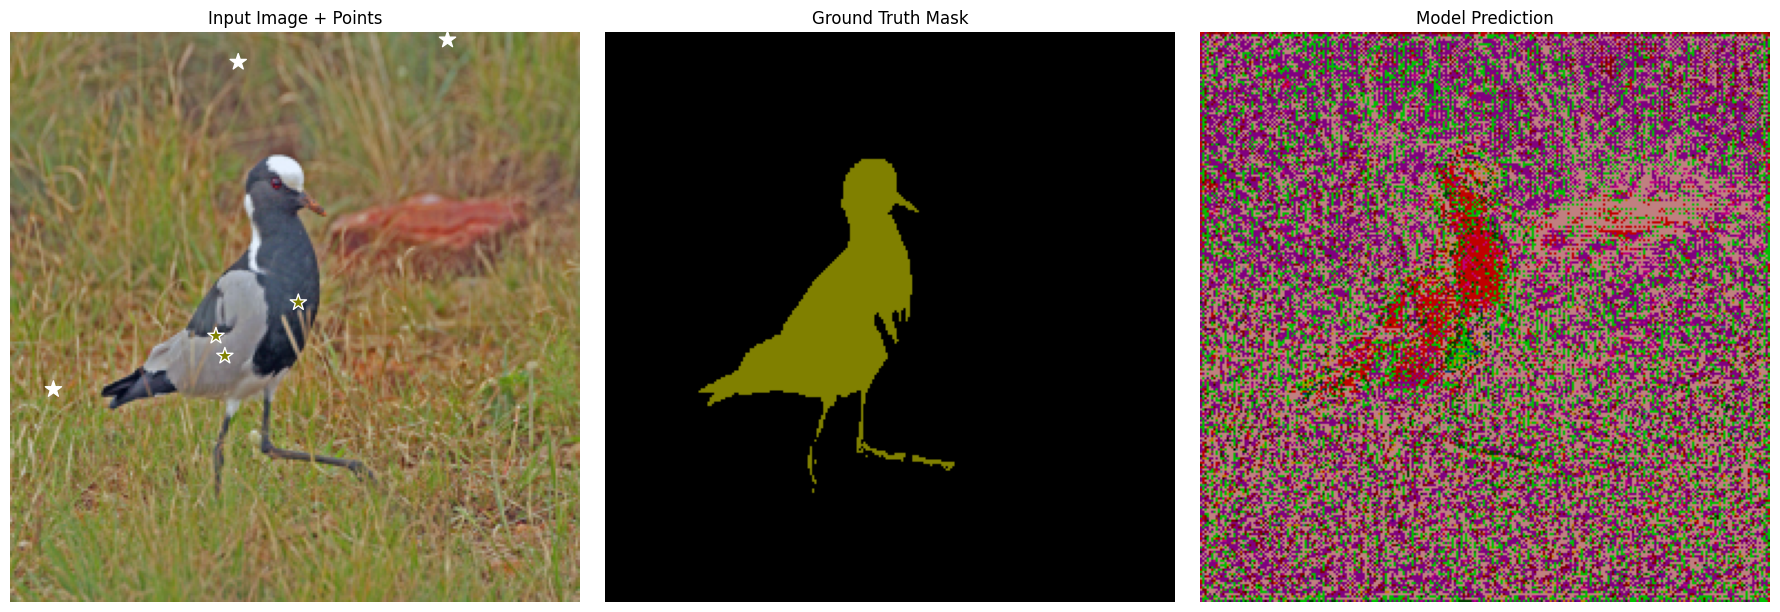

In [ ]:
train_on_batch(model, train_loader, n_epochs=1)

# U-net

In [ ]:

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
def train_step(model, dataloader, criterion_ce, criterion_dice , optimizer, device):
    model.train()
    train_loss = 0.0
    for images, masks, points in dataloader:
        images, masks = (
            images.to(device),
            masks.squeeze(dim=1).to(device),
        )
        # print("Model")
        logits = model(images)
        # print(1)
        # print(logits.shape)
        # print(masks.shape)
        loss_ce = criterion_ce(logits, masks)
        # print(2)
        loss_dice = criterion_dice(logits.float(), masks)
        # print(3)
        total_loss = loss_ce + loss_dice
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += total_loss.item()
    train_loss /= len(dataloader)
    return train_loss


def test_step(model, dataloader, criterion_ce, criterion_dice, device):
    model.eval()
    test_loss = 0.0
    with torch.inference_mode():
        for images, masks, points in dataloader:
            images, masks = (
                images.to(device),
                masks.squeeze(dim=1).to(device),
            )
            logits = model(images)
            loss_ce = criterion_ce(logits, masks)
            loss_dice = criterion_dice(logits.float(), masks)
            total_loss = loss_ce + loss_dice
            test_loss += total_loss.item()
        test_loss /= len(dataloader)
    return test_loss


def train_model(model, train_dataloader, test_dataloader, n_epochs, device=device):
    history = {"train_loss": [], "test_loss": []}
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion_dice = DiceLoss(n_classes=N_CLASSES, ignore_index=IGNORE_INDEX)
    criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    for _ in (pbar := trange(n_epochs)):
        # print("Loop")
        # print("Train")
        train_loss = train_step(model, train_dataloader, criterion_ce, criterion_dice , optimizer, device)
        history["train_loss"].append(train_loss)
        # print("Test")
        test_loss = test_step(model, test_dataloader, criterion_ce, criterion_dice, device)
        history["test_loss"].append(test_loss)
        pbar.set_description(
            f"Training Loss {train_loss:.3f} | Test Loss {test_loss:.3f}"
        )
        torch.save(model.state_dict(), "./drive/MyDrive/u-net-seg.pth")
        if test_loss < 0.9:
          break
    return history



def evaluate_images(model, batch):
    model.eval()
    with torch.inference_mode():
        images, masks, points = batch
        images, masks = (
            images.to(device),
            masks.to(device),
        )
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)

        # --- Coordinate and Color Extraction ---
        # Find the indices of all non-background points
        point_indices = torch.where(points[0] > 0)

        # 🔧 FIXED LINE: Convert labels to long (integer) before converting to NumPy
        point_labels = points[0][point_indices].long().cpu().numpy()

        # Get the (x, y) coordinates for each point
        y_coords = point_indices[1]
        x_coords = point_indices[2]
        plot_coords = torch.stack([x_coords, y_coords], dim=1)

        # Map the integer labels to their corresponding colors
        point_colors = VOC_COLOR_MAP[point_labels] / 255.0

        # Call the helper function (no changes needed for show_predictions)
        show_predictions(
        image=images[0],
        mask=masks[0],
        prediction=predictions[0],
        point_coords=plot_coords,
        point_colors=point_colors
        )

    return images, masks, logits



In [ ]:
unet = UNet(n_channels=3, n_classes=N_CLASSES, bilinear=False).to(device)

In [ ]:
results = train_model(unet, train_loader, val_loader, n_epochs=10)

Training Loss 1.981 | Test Loss 1.981: 100%|██████████| 10/10 [29:24<00:00, 176.44s/it]


In [ ]:
results

{'train_loss': [2.079985017333526,
  2.0593630596588217,
  2.05142891602438,
  2.0390643148474354,
  2.022401107464983,
  2.023150897416912,
  2.015049585879175,
  1.9935461080790868,
  1.994726455928198,
  1.9811034463142436],
 'test_loss': [2.0638242187080804,
  2.0567439316393257,
  2.0964702629781033,
  2.054239511489868,
  2.046186646917364,
  2.025241019306602,
  2.079616272842491,
  2.026688184056963,
  2.0197664427233266,
  1.9810799543674176]}

In [ ]:
unet

# U-net + vgg

In [ ]:

class UNetPretrained(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetPretrained, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear


        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # Use the 'features' part of VGG16 as the backbone
        self.features = vgg16.features

        # Freeze the backbone parameters
        for param in self.features.parameters():
            param.requires_grad = False


        self.up1 = Up(1024, 512, True)
        self.up2 = Up(512, 256, False)
        self.up3 = Up(256, 128, False)
        self.up4 = Up(128, 64, False)

        self.inc = DoubleConv(n_channels, 64)
        self.feature_extractors = [
            self.inc,
            self.features[5:10],
            self.features[10:17],
            self.features[17:24],
            self.features[24:],
        ]

        self.outc = OutConv(64, n_classes)

    def forward(self, x):

        x1 = self.feature_extractors[0](x)
        # print(f"x1 shape: {x1.shape}")
        x2 = self.feature_extractors[1](x1)
        # print(f"x2 shape: {x2.shape}")
        x3 = self.feature_extractors[2](x2)
        # print(f"x3 shape: {x3.shape}")
        x4 = self.feature_extractors[3](x3)
        # print(f"x4 shape: {x4.shape}")
        x5 = self.feature_extractors[4](x4)
        # print(f"x5 shape: {x5.shape}")


        x = self.up1(x5, x4)
        # print(f"up1 shape: {x.shape}")

        x = self.up2(x, x3)
        # print(f"up2 shape: {x.shape}")

        x = self.up3(x, x2)
        # print(f"up3 shape: {x.shape}")

        x = self.up4(x, x1)
        # print(f"up4 shape: {x.shape}")

        x = self.outc(x)
        # print(f"outc shape: {x.shape}")
        return x


In [ ]:
unet_vgg = UNetPretrained(n_channels=3, n_classes=N_CLASSES, bilinear=False).to(device)

In [ ]:
results = train_model(unet_vgg, train_loader, val_loader, n_epochs=19)

Training Loss 1.406 | Test Loss 1.635: 100%|██████████| 20/20 [1:22:28<00:00, 247.45s/it]


In [ ]:
results # my model: Training Loss 1.379 | Test Loss 1.547

{'train_loss': [2.3631605821880486,
  2.022164538909829,
  1.928622258816912,
  1.8449001110316625,
  1.7930380425166563,
  1.7545138011213208,
  1.7205243859786155,
  1.696865517585004,
  1.6740919156152694,
  1.6617862657119669,
  1.6216115554173787,
  1.602968191839958,
  1.5653845000136746,
  1.5305545121594204,
  1.5114243037062265,
  1.4716281877840802,
  1.449955440609833,
  1.4225681225458782,
  1.410042233805839,
  1.4055162622628967],
 'test_loss': [2.0500067380758433,
  1.9700162083238035,
  1.855760627395504,
  1.8339436971224272,
  1.8031058200113066,
  1.7116961079639392,
  1.7051952415770226,
  1.6587723211927727,
  1.6767764248690762,
  1.6387572229563534,
  1.7741324233484792,
  1.6307224952257597,
  1.6025397178235945,
  1.6353965735697484,
  1.6235969040420029,
  1.6214769842860464,
  1.6628320459481125,
  1.6461784020885006,
  1.627790975046682,
  1.635216610117273]}

In [ ]:
def train_step(model, dataloader, criterion_ce, criterion_dice , optimizer, device):
    model.train()
    train_loss = 0.0
    for images, masks, points in dataloader:
        images, masks = (
            images.to(device),
            masks.squeeze(dim=1).to(device),
        )
        logits = model(images)
        loss_ce = criterion_ce(logits, masks)
        loss_dice = criterion_dice(logits.float(), masks)
        total_loss = loss_ce + loss_dice
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += total_loss.item()

    train_loss /= len(dataloader)
    return train_loss


def test_step(model, dataloader, criterion_ce, criterion_dice, device):
    model.eval()
    test_loss = 0.0
    with torch.inference_mode():
        for images, masks, points in dataloader:
            images, masks = (
                images.to(device),
                masks.squeeze(dim=1).to(device),
            )
            logits = model(images)
            loss_ce = criterion_ce(logits, masks)
            loss_dice = criterion_dice(logits.float(), masks)
            total_loss = loss_ce + loss_dice
            test_loss += total_loss.item()

        test_loss /= len(dataloader)
    return test_loss


def train_model(model, train_dataloader, test_dataloader, n_epochs, device=device):
    history = {"train_loss": [], "test_loss": []}
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion_dice = DiceLoss(n_classes=N_CLASSES, ignore_index=IGNORE_INDEX)
    criterion_ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    for _ in (pbar := trange(n_epochs)):
        # print("Loop")
        # print("Train")
        train_loss = train_step(model, train_dataloader, criterion_ce, criterion_dice , optimizer, device)
        history["train_loss"].append(train_loss)
        # print("Test")
        test_loss = test_step(model, test_dataloader, criterion_ce, criterion_dice, device)
        history["test_loss"].append(test_loss)
        pbar.set_description(
            f"Training Loss {train_loss:.3f} | Test Loss {test_loss:.3f}"
        )
        torch.save(model.state_dict(), "./drive/MyDrive/u-net-vgg16.pth")
        if test_loss < 0.9:
          break
    return history



def evaluate_images(model, batch):
    model.eval()
    with torch.inference_mode():
        images, masks, points = batch
        images, masks = (
            images.to(device),
            masks.squeeze(dim=1).to(device),
        )
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)

        # --- Coordinate and Color Extraction ---
        # Find the indices of all non-background points
        point_indices = torch.where(points[0] > 0)

        # 🔧 FIXED LINE: Convert labels to long (integer) before converting to NumPy
        point_labels = points[0][point_indices].long().cpu().numpy()

        # Get the (x, y) coordinates for each point
        y_coords = point_indices[1]
        x_coords = point_indices[2]
        plot_coords = torch.stack([x_coords, y_coords], dim=1)

        # Map the integer labels to their corresponding colors
        point_colors = VOC_COLOR_MAP[point_labels] / 255.0

        # Call the helper function (no changes needed for show_predictions)
        show_predictions(
        image=images[0],
        mask=masks[0],
        prediction=predictions[0],
        point_coords=plot_coords,
        point_colors=point_colors
        )

    return images, masks, logits



In [ ]:

def show_predictions(image, mask, prediction, point_coords, point_colors):
    """Plots the image, masks, and points with per-class coloring."""
    # Detach tensors and move to CPU
    image_np = image.detach().cpu().permute(1, 2, 0).numpy()
    mask_np = mask.detach().cpu().numpy()
    prediction_np = prediction.detach().cpu().numpy()
    points_np = point_coords.detach().cpu().numpy()
    # point_colors is already a NumPy array, no conversion needed

    # Normalize image for display
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Input Image with Colored Points
    axes[0].imshow(image_np)
    axes[0].scatter(
        points_np[:, 0], # x coordinates
        points_np[:, 1], # y coordinates
        c=point_colors,  # Use the list of colors for each point
        marker='*',
        s=150,
        edgecolor='white', # White edge helps visibility on dark colors
        linewidth=1
    )
    axes[0].set_title("Input Image + Points")
    axes[0].axis('off')

    # Plot Masks (no changes)
    axes[1].imshow(mask_to_rgb(mask_np, VOC_COLOR_MAP), cmap='viridis')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    axes[2].imshow(mask_to_rgb(prediction_np, VOC_COLOR_MAP), cmap='viridis')
    axes[2].set_title("Model Prediction")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
batch = next(iter(val_loader))

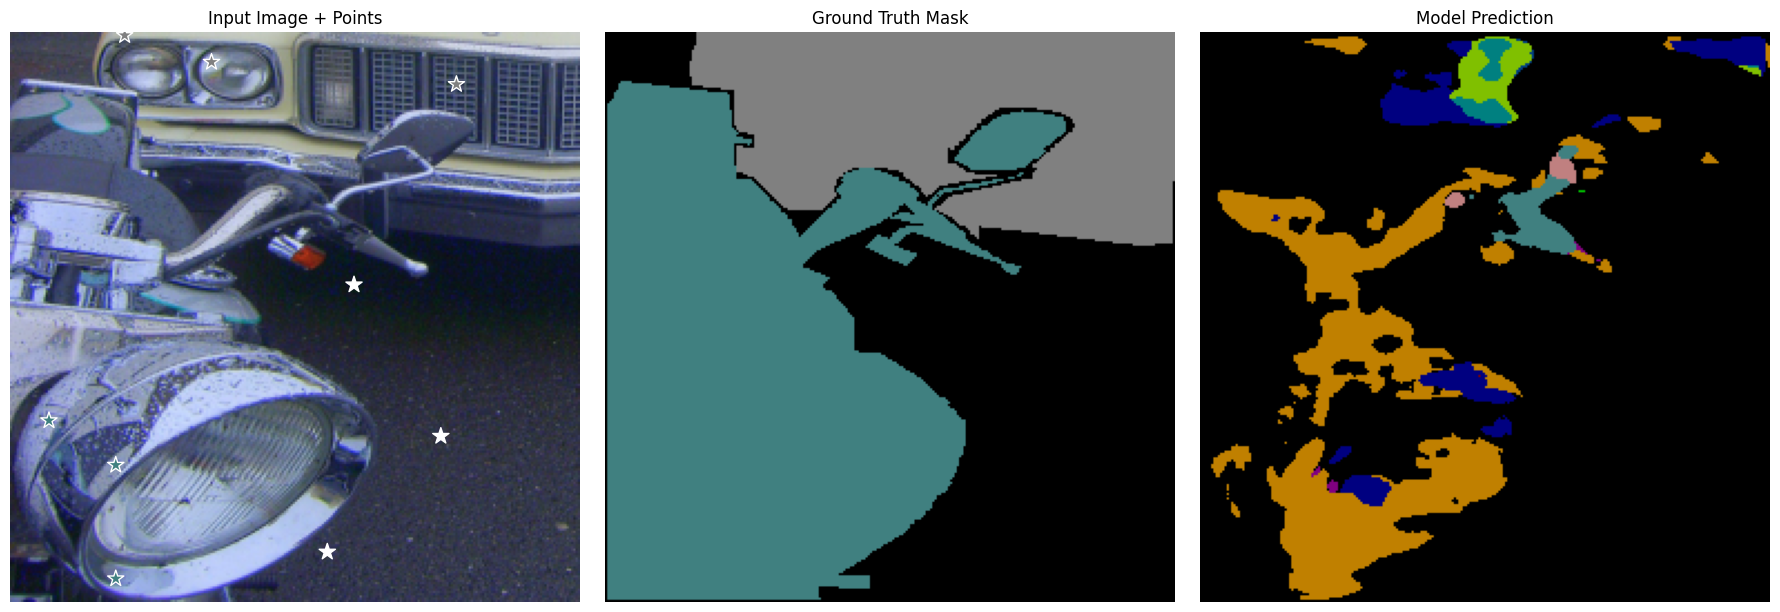

In [ ]:
a = evaluate_images(unet_vgg,batch)

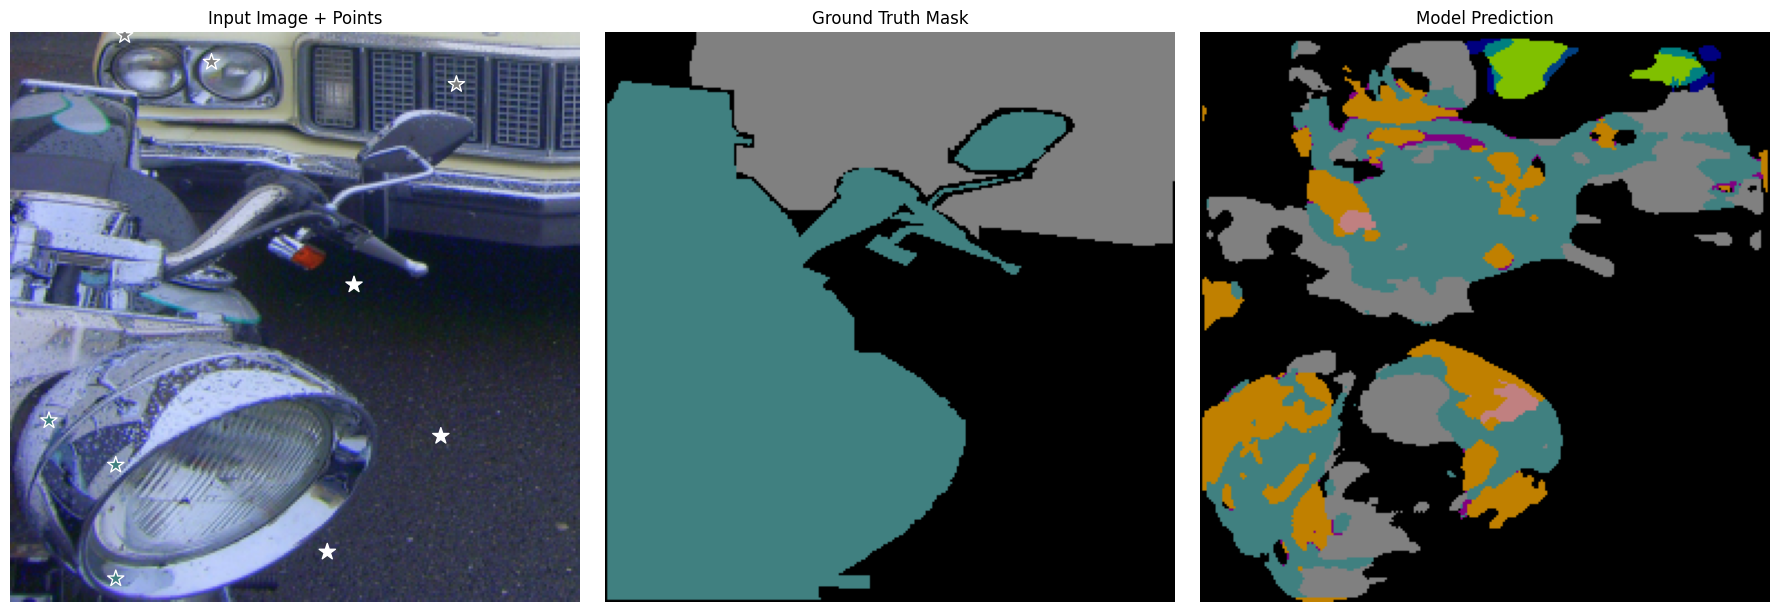

In [ ]:
a = my_evaluate_images(model,batch)

In [ ]:
imgs, masks, pts =  batch

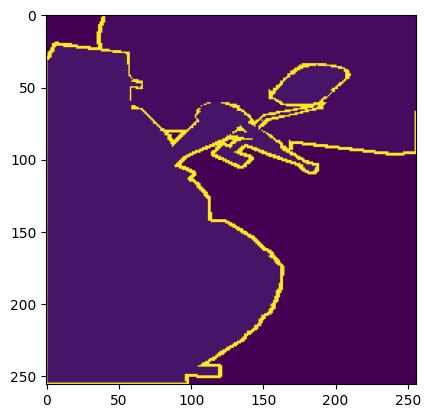

In [ ]:
plt.imshow(masks[0].permute(1,2,0))

<All keys matched successfully>